In [1]:
from pathlib import Path
import re
from datetime import datetime
import os

from eolearn.geometry.transformations import RasterToVector, VectorToRaster
from eolearn.io.local_io import ImportFromTiff
from eolearn.core import OverwritePermission, FeatureType, MergeEOPatchesTask
from eolearn.io import ExportToTiff, VectorImportTask
from eolearn.core import EOPatch

import matplotlib.pyplot as plt

import numpy as np
import scipy

In [2]:
class Sentinel2():
    """
    Works for Sentinel-2 Level-2A
    """
    def __init__(self, fpath):
        """
        Read data as lists
        """
        self.fpath = str(fpath)
#         self.fname =  self.fpath.stem
        self.date = self._get_date()
#         self.bname = self._get_band_name(band_type)
        # patterns = ['*_SR_B*', '*_ST_B*']
        # self.band_flist = [f for f in path.iterdir() if any(f.match(p) for p in patterns)]
    
    def read(self):
        # eop_list = []
        
        # for fband in self.band_flist:
        # Read Landsat tiff
        eop = ImportFromTiff(feature=(FeatureType.DATA, 'Sentinel-2'),
                               folder=self.fpath,
                               image_dtype=np.float32,
                               no_data_value=0
                                )
        self.eop = eop.execute()
        self.eop.timestamp = [self.date]
        
        # eop_list.append(eop)
            
        # eop_merge = MergeEOPatchesTask()
        # eop_merge = eop_merge.execute(*eop_list)
        
            
        return self.eop
    
    def write(self, outpath):
        outpath = Path(outpath)
        # save and keep projection to UTM
        export_tiff = ExportToTiff(feature=(FeatureType.DATA, 'Sentinel-2'),
                                   folder=outpath/f'RT_{os.path.basename(self.fpath)}',
                                   date_indices=None,
                                   no_data_value=0,
                                   image_dtype=np.float32)
        export_tiff.execute(self.eop);
    
    def radcorr(self, divide):
        self.eop.data['Sentinel-2'][self.eop.data['Sentinel-2'] != 0] = self.eop.data['Sentinel-2'][self.eop.data['Sentinel-2'] != 0] / divide
        
    def _get_date(self):
        """
        Get date from band filename
        """
        date = self.fpath
        
        pattern =  r'_MSIL.*_([0-9]{8}T[0-9]{6})_N.*'
        result = re.findall(pattern, date)[0]
        
        return datetime.strptime(result, '%Y%m%dT%H%M%S')
    
#     def _get_band_name(self, band_type):
#         pattern = fr'{band_type}_(B[1-9]+)$'
#         result = re.findall(pattern, self.fname)[0]
        
        return result

In [3]:
fpath = '/home/AOIs/polyphytos/young_research_data/sen2cor'
fname = 'from_miscellaneous/salo/RT_Subset_S2A_MSIL2A_20210420T100021_N0300_R122_T34VEM_20210420T114413_resampled.tif'
base_path = Path(fpath)/fname

In [4]:
# Read data
sentinel2 = Sentinel2(base_path)
sentinel2.read()

EOPatch(
  data: {
    Sentinel-2: numpy.ndarray(shape=(1, 2564, 3158, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: [datetime.datetime(2021, 4, 20, 10, 0, 21)]
)

In [5]:
# record metadata
sentinel2.eop.meta_info['time'], sentinel2.eop.meta_info['height'], sentinel2.eop.meta_info['width'], sentinel2.eop.meta_info['bands'] = sentinel2.eop.data['Sentinel-2'].shape
sentinel2.eop.meta_info['band_names'] = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
sentinel2.eop

EOPatch(
  data: {
    Sentinel-2: numpy.ndarray(shape=(1, 2564, 3158, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    band_names: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    bands: 10
    height: 2564
    time: 1
    width: 3158
  }
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: [datetime.datetime(2021, 4, 20, 10, 0, 21)]
)

In [6]:
# Save ORIGINAL DATA
sentinel2.eop.save(os.path.join(fpath, 'from_miscellaneous/salo/S2L2A_20210420_unseen'), [(FeatureType.DATA, 'Sentinel-2'),
                                                                                                                                   (FeatureType.META_INFO, 'band_names'),
                                                                                                                                   (FeatureType.BBOX,),
                                                                                                                                   (FeatureType.TIMESTAMP,)],
         compress_level=5,
         overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [15]:
# Read labels geoTIFF
eop = ImportFromTiff(feature=(FeatureType.MASK_TIMELESS, 'labels'),
                       folder='/home/AOIs/polyphytos/young_research_data/geometry/labels2.tif',
                       image_dtype=np.uint8,
                       no_data_value=255
                    )
eop = eop.execute()

# pass labels in data eopatch
sentinel2.eop.mask_timeless['labels'] = eop.mask_timeless['labels']
# pass label metadata
sentinel2.eop.meta_info['muddy'], sentinel2.eop.meta_info['non_muddy'] = 1, 0

In [16]:
sentinel2.eop

EOPatch(
  data: {
    Sentinel-2: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    labels: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    bands: 10
    height: 2185
    muddy: 1
    non_muddy: 0
    time: 1
    width: 2439
  }
  bbox: BBox(((569630.0, 4440010.0), (594020.0, 4461860.0)), crs=CRS('32634'))
  timestamp: [datetime.datetime(2021, 12, 24, 9, 24, 11)]
)

In [17]:
# Create masks for muddy and non_muddy classes (image with pixel=1 if muddy, pixel=0 if non muddy)
sentinel2.eop.mask['muddy'] = np.expand_dims(np.transpose(sentinel2.eop.mask_timeless['labels'] == 1, (2, 0, 1)), axis=3)
sentinel2.eop.mask['non_muddy'] = np.expand_dims(np.transpose(sentinel2.eop.mask_timeless['labels'] == 0, (2, 0, 1)), axis=3)
sentinel2.eop

EOPatch(
  data: {
    Sentinel-2: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
  }
  mask: {
    muddy: numpy.ndarray(shape=(1, 2185, 2439, 1), dtype=bool)
    non_muddy: numpy.ndarray(shape=(1, 2185, 2439, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    labels: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    bands: 10
    height: 2185
    muddy: 1
    non_muddy: 0
    time: 1
    width: 2439
  }
  bbox: BBox(((569630.0, 4440010.0), (594020.0, 4461860.0)), crs=CRS('32634'))
  timestamp: [datetime.datetime(2021, 12, 24, 9, 24, 11)]
)

In [41]:
# make scalar
sentinel2.eop.scalar['muddy'] = sentinel2.eop.data['Sentinel-2'].reshape(sentinel2.eop.meta_info['time']*sentinel2.eop.meta_info['height']*sentinel2.eop.meta_info['width'], sentinel2.eop.meta_info['bands'])[sentinel2.eop.mask['muddy'].reshape(sentinel2.eop.meta_info['time']*sentinel2.eop.meta_info['height']*sentinel2.eop.meta_info['width']), :]
sentinel2.eop.scalar['non_muddy'] = sentinel2.eop.data['Sentinel-2'].reshape(sentinel2.eop.meta_info['time']*sentinel2.eop.meta_info['height']*sentinel2.eop.meta_info['width'], sentinel2.eop.meta_info['bands'])[sentinel2.eop.mask['non_muddy'].reshape(sentinel2.eop.meta_info['time']*sentinel2.eop.meta_info['height']*sentinel2.eop.meta_info['width']), :]
sentinel2.eop

EOPatch(
  data: {
    Sentinel-2: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
  }
  mask: {
    muddy: numpy.ndarray(shape=(1, 2185, 2439, 1), dtype=bool)
    non_muddy: numpy.ndarray(shape=(1, 2185, 2439, 1), dtype=bool)
  }
  scalar: {
    muddy: numpy.ndarray(shape=(15607, 10), dtype=float32)
    non_muddy: numpy.ndarray(shape=(86673, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    labels: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    band_names: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    bands: 10
    height: 2185
    muddy: 1
    non_muddy: 0
    time: 1
    width: 2439
  }
  bbox: BBox(((569630.0, 4440010.0), (594020.0, 4461860.0)), crs=CRS('32634'))
  timestamp: [datetime.datetime(2021, 12, 19, 9, 23, 9)]
)

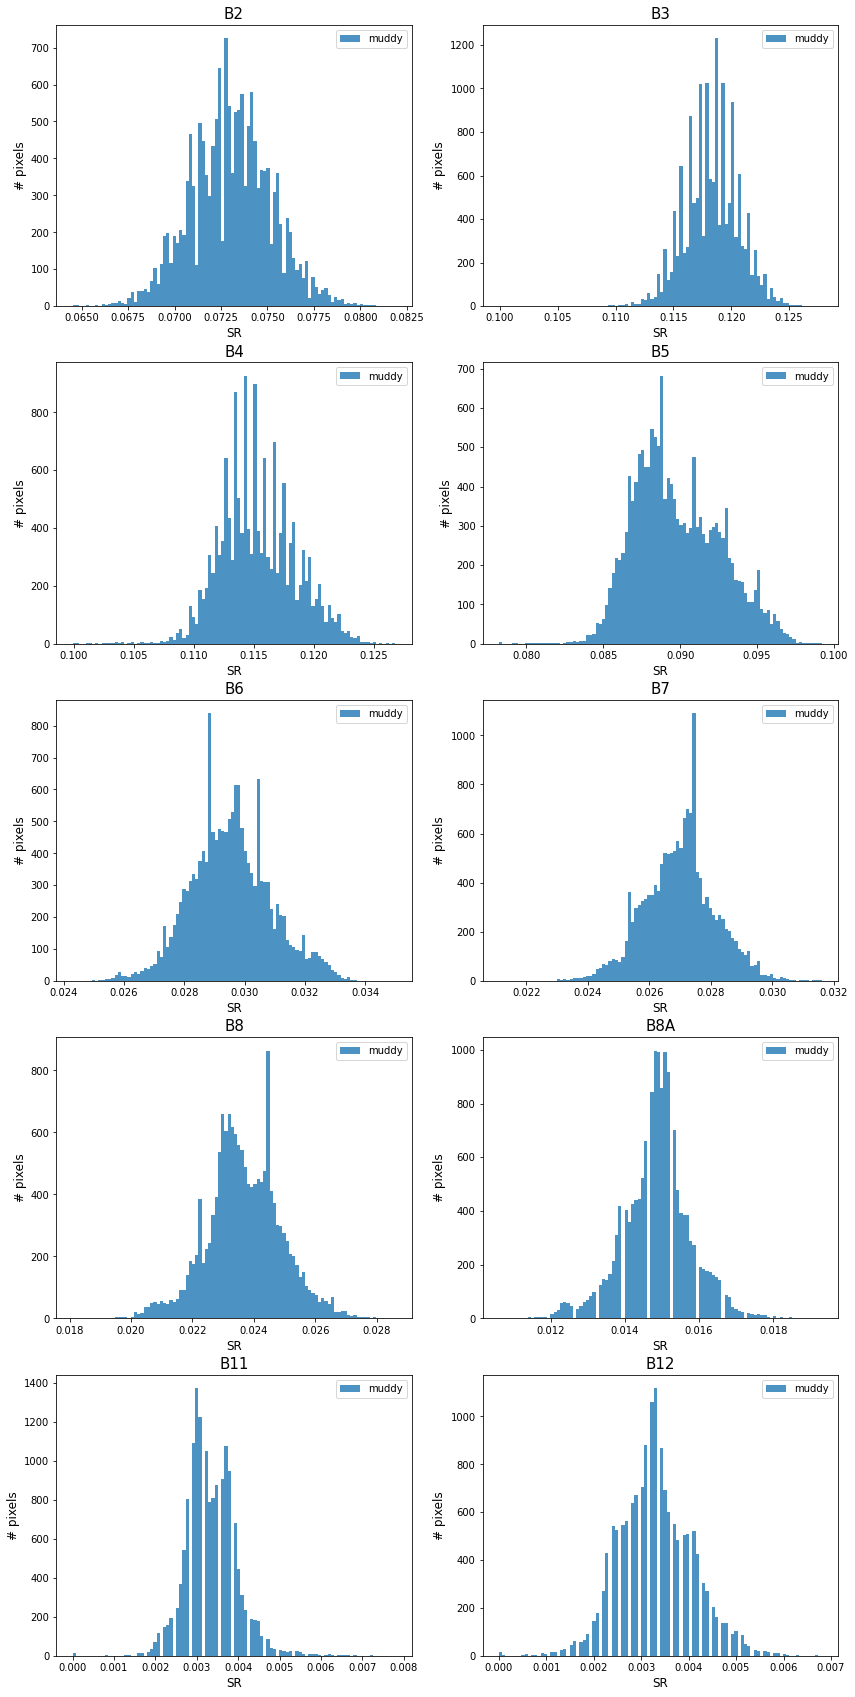

In [22]:
# Check histograms
fig, axes = plt.subplots(figsize=(14, 30), ncols=2, nrows=5)

for i, ax in enumerate(axes.ravel()):
#     idx = 0
    ax.hist(sentinel2.eop.scalar['muddy'][:, i], bins=100, alpha=0.8);
    ax.set_title(sentinel2.eop.meta_info['band_names'][i], fontsize=15)
    ax.set_xlabel('SR', fontsize=12)
    ax.set_ylabel('# pixels', fontsize=12)
    ax.legend(labels=['muddy']);

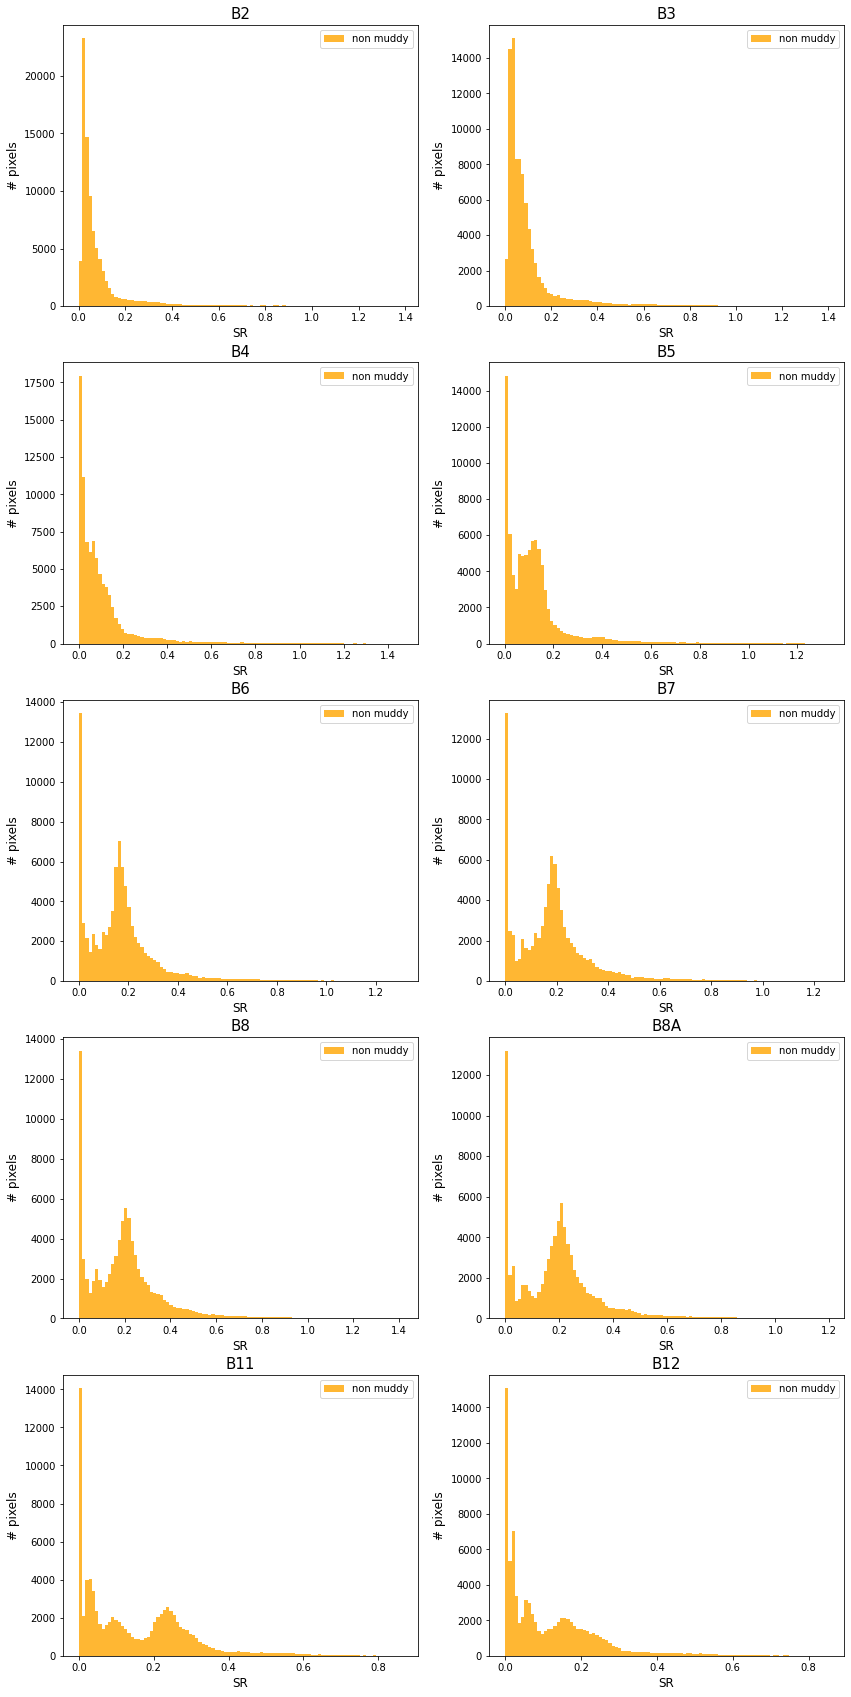

In [23]:
# Check histograms
fig, axes = plt.subplots(figsize=(14, 30), ncols=2, nrows=5)

for i, ax in enumerate(axes.ravel()):
    ax.hist(sentinel2.eop.scalar['non_muddy'][:, i], bins=100, alpha=0.8, color='orange');
    ax.set_title(sentinel2.eop.meta_info['band_names'][i], fontsize=15)
    ax.set_xlabel('SR', fontsize=12)
    ax.set_ylabel('# pixels', fontsize=12)
    ax.legend(labels=['non muddy']);

In [43]:
# Check for nan, inf and zeros
print('Muddy')
print(np.isnan(sentinel2.eop.scalar['muddy'].ravel()).sum(), np.isinf(sentinel2.eop.scalar['muddy'].ravel()).sum(), (sentinel2.eop.scalar['muddy'].ravel() == 0).sum())
print('Non muddy')
print(np.isnan(sentinel2.eop.scalar['non_muddy'].ravel()).sum(), np.isinf(sentinel2.eop.scalar['non_muddy'].ravel()).sum(), (sentinel2.eop.scalar['non_muddy'].ravel() == 0).sum())

Muddy
0 0 32
Non muddy
0 0 5067


In [47]:
# Clearn from zeros Muddy
muddy_mask = sentinel2.eop.scalar['muddy'] == 0
sentinel2.eop.scalar['muddy'] = sentinel2.eop.scalar['muddy'][~np.any(muddy_mask, axis=1), :]
sentinel2.eop.scalar['muddy'].shape

(15575, 10)

In [48]:
# Clearn from zeros Muddy
nonmuddy_mask = sentinel2.eop.scalar['non_muddy'] == 0
sentinel2.eop.scalar['non_muddy'] = sentinel2.eop.scalar['non_muddy'][~np.any(nonmuddy_mask, axis=1), :]
sentinel2.eop.scalar['non_muddy'].shape

(82462, 10)

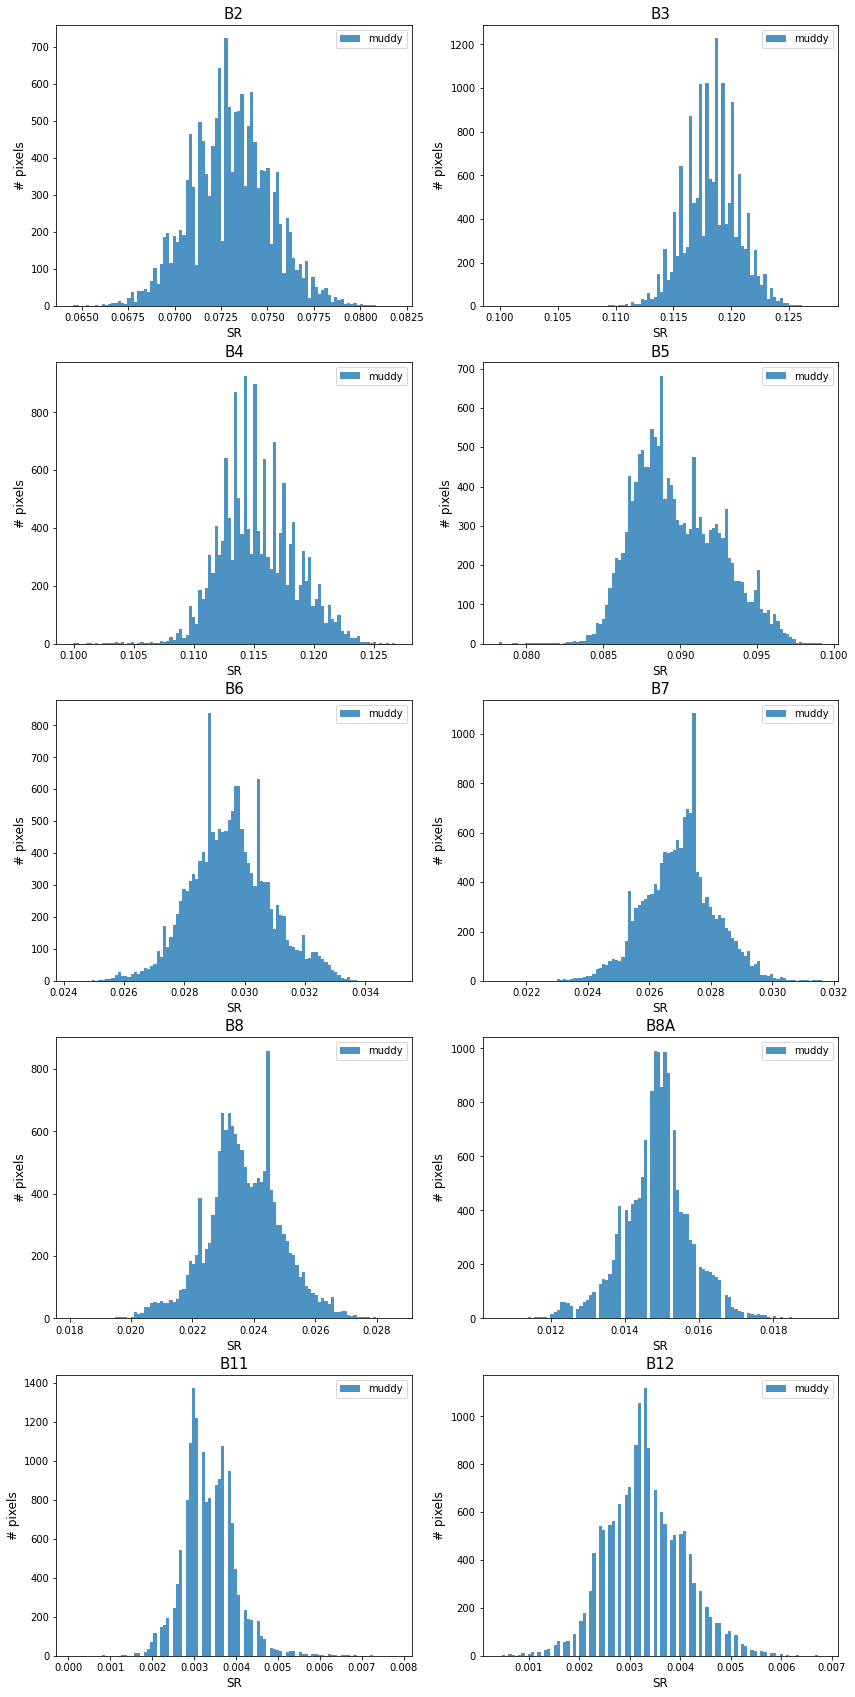

In [56]:
# Check histograms
fig, axes = plt.subplots(figsize=(14, 30), ncols=2, nrows=5)

for i, ax in enumerate(axes.ravel()):
#     idx = 0
    ax.hist(sentinel2.eop.scalar['muddy'][:, i], bins=100, alpha=0.8);
    ax.set_title(sentinel2.eop.meta_info['band_names'][i], fontsize=15)
    ax.set_xlabel('SR', fontsize=12)
    ax.set_ylabel('# pixels', fontsize=12)
    ax.legend(labels=['muddy']);

In [57]:
fig.savefig('/home/AOIs/polyphytos/hist_muddy.png', dpi=300, bbox_inches='tight')

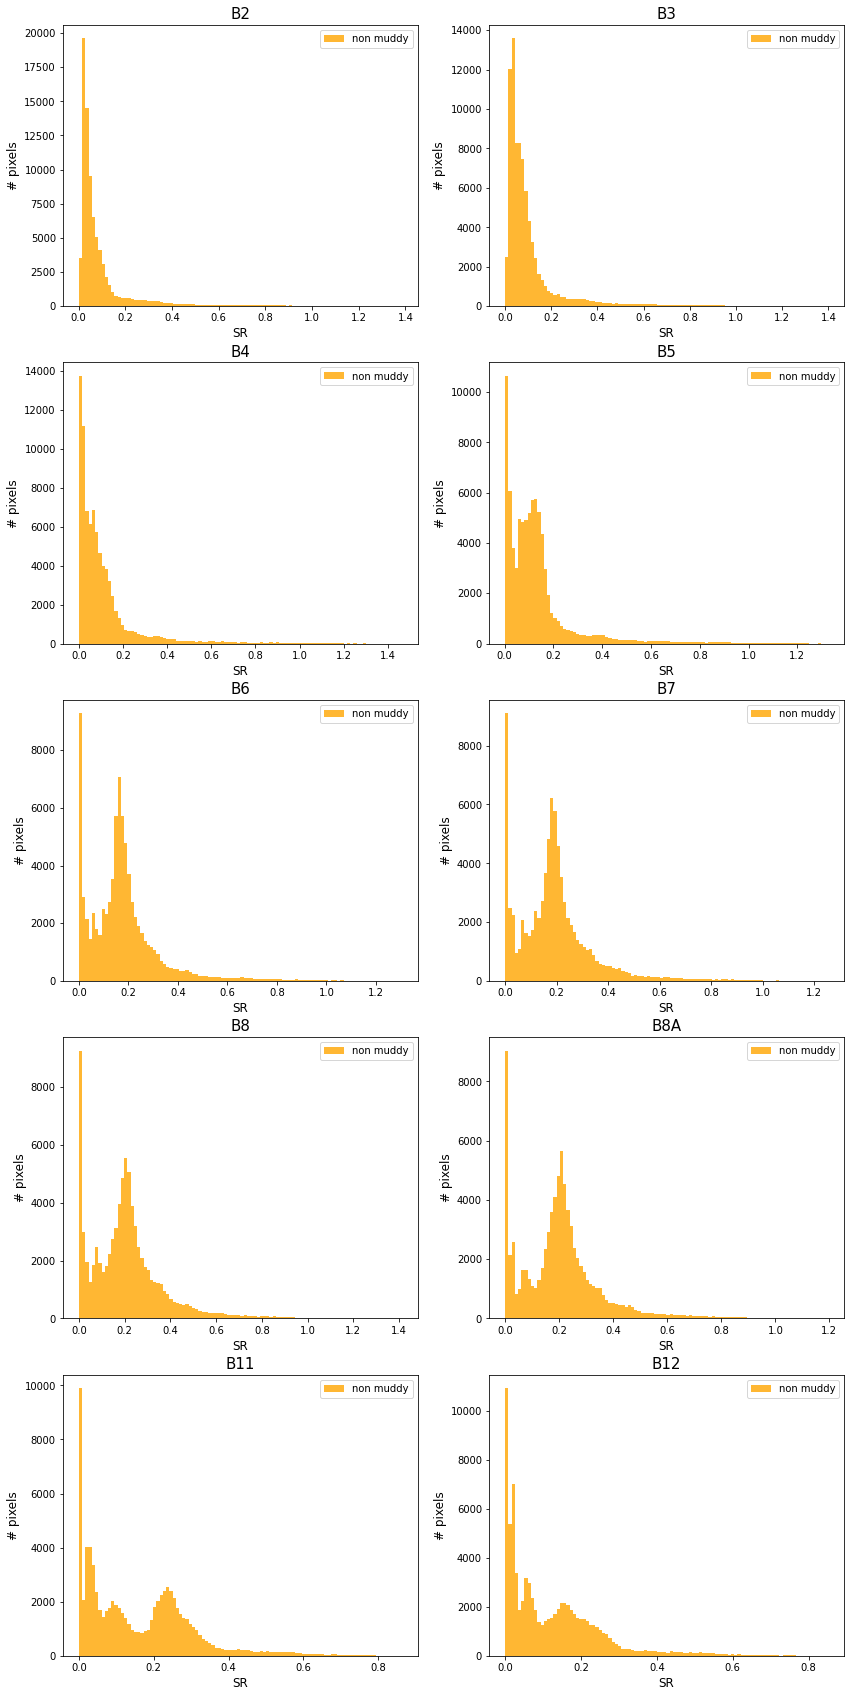

In [58]:
# Check histograms
fig, axes = plt.subplots(figsize=(14, 30), ncols=2, nrows=5)

for i, ax in enumerate(axes.ravel()):
    ax.hist(sentinel2.eop.scalar['non_muddy'][:, i], bins=100, alpha=0.8, color='orange');
    ax.set_title(sentinel2.eop.meta_info['band_names'][i], fontsize=15)
    ax.set_xlabel('SR', fontsize=12)
    ax.set_ylabel('# pixels', fontsize=12)
    ax.legend(labels=['non muddy']);

In [59]:
fig.savefig('/home/AOIs/polyphytos/hist_nonmuddy.png', dpi=300, bbox_inches='tight')

In [61]:
# Needs change
idx = 0
scipy.stats.describe(sentinel2.eop.scalar['muddy'][:, idx]), scipy.stats.describe(sentinel2.eop.scalar['non_muddy'][:, idx])

(DescribeResult(nobs=15575, minmax=(0.0645, 0.0819), mean=0.073049255, variance=4.725223e-06, skewness=0.03133835271000862, kurtosis=0.08920680388472801),
 DescribeResult(nobs=82462, minmax=(0.0015, 1.3848), mean=0.096774034, variance=0.020144183, skewness=3.5394797325134277, kurtosis=14.764550521453526))

In [54]:
# Save SCALAR
sentinel2.eop.save('/home/AOIs/polyphytos/young_research_data/S2L2A_20211219_train', [(FeatureType.SCALAR, 'muddy'), (FeatureType.SCALAR, 'non_muddy'),
                                                                                      (FeatureType.META_INFO, 'band_names'), (FeatureType.META_INFO, 'muddy'),
                                                                                      (FeatureType.META_INFO, 'non_muddy')],
         compress_level=5,
         overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

#### Import scene classification geoTIFF in order to choose random pixels per class (Obsolete but **not** invalid)

In [ ]:
# Read scene classification tiff
eop = ImportFromTiff(feature=(FeatureType.MASK_TIMELESS, 'SCL'),
                       folder='/home/AOIs/polyphytos/young_research_data/Subset_S2B_MSIL2A_20211219T092309_N0301_R093_T34TEK_20211219T120442_scl.tif',
                       image_dtype=np.uint8
#                        no_data_value=0
                        )
eop = eop.execute()

eop.meta_info['scl_names'] = [
('NODATA', 0),
('SATURATED_DEFECTIVE', 1),
('DARK_FEATURE_SHADOW', 2),
('CLOUD_SHADOW', 3),
('VEGETATION', 4),
('NOT_VEGETATED', 5),
('WATER', 6),
('UNCLASSIFIED', 7),
('CLOUD_MEDIUM_PROBA', 8),
('CLOUD_HIGH_PROBA', 9),
('THIN_CIRRUS', 10),
('SNOW_ICE', 11)
]
# Pass SCL to sentinel2 eop
sentinel2.eop.mask_timeless['SCL'] = eop.mask_timeless['SCL']
sentinel2.eop.meta_info['scl_names'] = eop.meta_info['scl_names']
sentinel2.eop
eop = landsat_eop.merge(landsat_eop2, timeless_op='concatenate').merge(landsat_eop3, timeless_op='concatenate')
eop.meta_info['time'], eop.meta_info['height'], eop.meta_info['width'], eop.meta_info['bands'] = eop.data['Landsat-5'].shape
eop